In [97]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('Folds5x2_pp.xlsx')

#1(b)i.

rows, cols = df.shape #counts number of rows and columns
print("Number of rows:", rows)
print("Number of columns:", cols)
print(df.columns)
print("\nThe rows represent hourly operation conditions of the power plant.")
print("The columns each represent a different factor affecting energy output.")

Number of rows: 9568
Number of columns: 5
Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

The rows represent hourly operation conditions of the power plant.
The columns each represent a different factor affecting energy output.


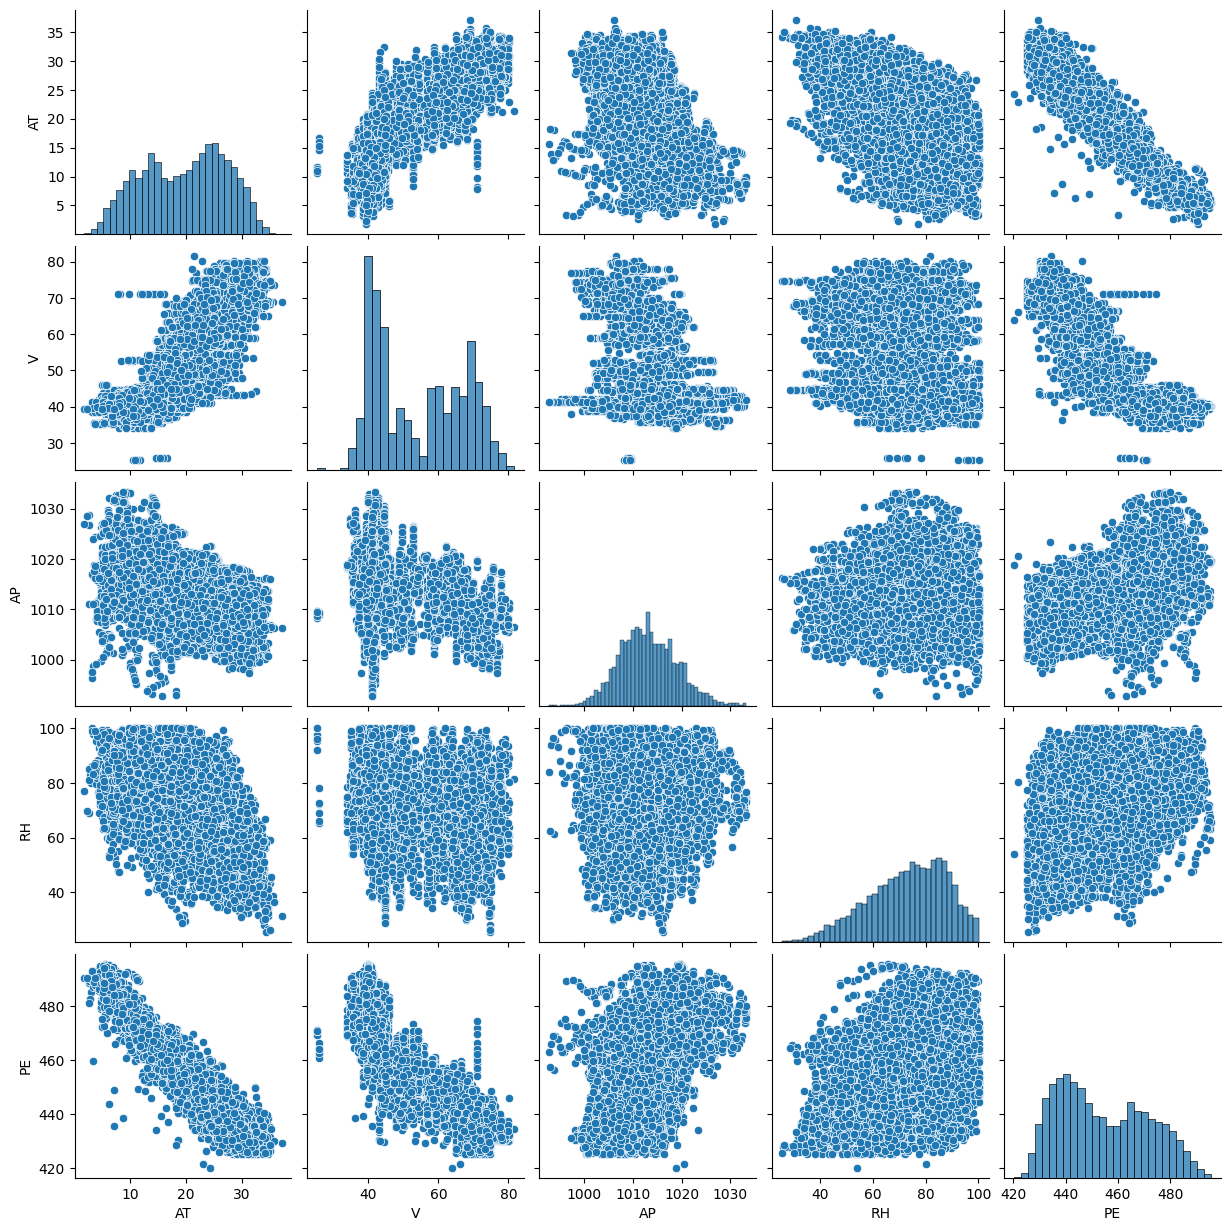

In [98]:
#1(b)ii.
import seaborn as sns

sns.pairplot(df)
plt.show()

Pairwise Scatterplot Findings:
1. Based on the scatterplots, we can see that Temperature (AT) and Exhaust Vacuum (V) are both negatively correlated with Power Output (PE) and are the most significant predictors.
2. The other two independent variables, Ambient Pressure (AP) and Relative Humidity (RH), show slight positive effects on the Power Output.
3. There may be muulticollinearity between Temperature (AT) and Exhaust Vacuum (V) based on their strong positive correlation.

In [99]:
#1(b)iii.

number = df.select_dtypes(include=['number']) #uses only numerical data

descriptiveStats = pd.DataFrame({ #listed out the summary statistics instead of describe() to include range and IQR
    "mean": number.mean(),
    "median (50%)": number.median(),
    "min": number.min(),
    "max": number.max(),
    "range": number.max() - number.min(),
    "Q1 (25%)": number.quantile(0.25),
    "Q3 (75%)": number.quantile(0.75),
    "IQR (Q3-Q1)": number.quantile(0.75) - number.quantile(0.25)
})

print(descriptiveStats)

           mean  median (50%)     min      max  range   Q1 (25%)  Q3 (75%)  \
AT    19.651231        20.345    1.81    37.11  35.30    13.5100     25.72   
V     54.305804        52.080   25.36    81.56  56.20    41.7400     66.54   
AP  1013.259078      1012.940  992.89  1033.30  40.41  1009.1000   1017.26   
RH    73.308978        74.975   25.56   100.16  74.60    63.3275     84.83   
PE   454.365009       451.550  420.26   495.76  75.50   439.7500    468.43   

    IQR (Q3-Q1)  
AT      12.2100  
V       24.8000  
AP       8.1600  
RH      21.5025  
PE      28.6800  


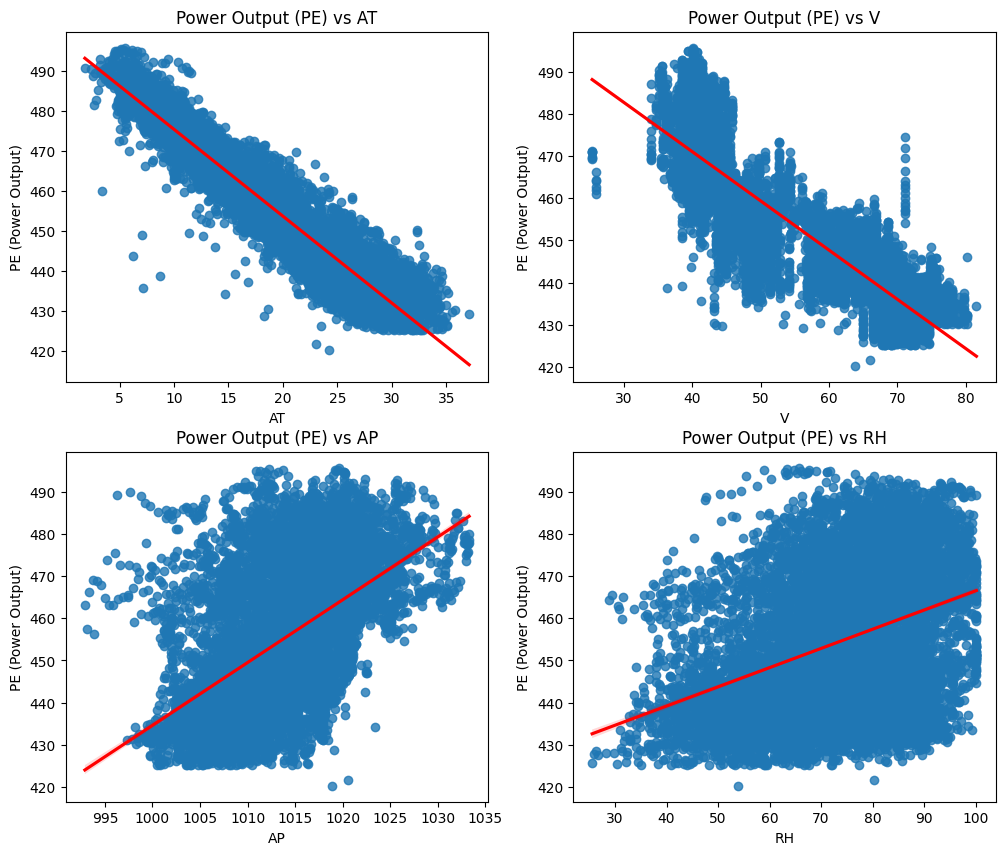


Regression Summary for AT:
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Sat, 15 Feb 2025   Prob (F-statistic):               0.00
Time:                        07:19:09   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.0341   

In [100]:
#1(c).

import statsmodels.api as sm
import numpy as np

#dependent variable
y = df["PE"]

#independent variables (predictors)
predictors = ["AT", "V", "AP", "RH"]

#dictionaries to store regression results and detected outliers
regression_results = {}
outliers_detected = {}

#create subplots for scatter plots with regression lines
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid layout
axes = axes.flatten()  # Flatten to loop through easily

#loop through each predictor variable to perform linear regression analysis
for i, predictor in enumerate(predictors):
    X = df[[predictor]]
    X = sm.add_constant(X)
    #OLS regression model
    model = sm.OLS(y, X).fit()
    #store the regression summary results
    regression_results[predictor] = model.summary()
    #scatter plot with a regression line
    sns.regplot(x=df[predictor], y=y, ax=axes[i], line_kws={"color": "red"})
    axes[i].set_title(f"Power Output (PE) vs {predictor}")
    axes[i].set_xlabel(predictor)
    axes[i].set_ylabel("PE (Power Output)")
plt.show()

#detect outliers
for predictor in predictors:
    X = sm.add_constant(df[predictor])
    model = sm.OLS(y, X).fit()
    #compute residuals (differences between actual and predicted values)
    df["residuals"] = model.resid
    #calculate z-scores
    df["z_score"] = (df["residuals"] - df["residuals"].mean()) / df["residuals"].std()
    #identify outliers where the absolute z-score is greater than 3
    outliers = df[np.abs(df["z_score"]) > 3][[predictor, "PE", "z_score"]]
    #store detected outliers for current predictor
    outliers_detected[predictor] = outliers

#regression summaries
for predictor, summary in regression_results.items():
    print(f"\nRegression Summary for {predictor}:")
    print(summary)

#display detected outliers for each predictor
for predictor, outliers in outliers_detected.items():
    print(f"\nOutliers detected in {predictor} model:")
    print(outliers)

Based on the regression tables between each independent variable and the dependent variable (PE), we can see that Temperature (AT) has a strong negative correlation with the dependent variable based on the negative coefficient of -2.1713. The high R-squared of 0.899 means that 89.9% of the variation in PE is explained by AT, making it the strongest predictor. This relationship is also statistically significant, indicated by the low p-value of 0.000. However, there are several outliers detected. Despite this, based on this regression analysis, Temperature (AT) is the most important factor affecting power output.

Exhaust Vacuum (V) also displays a strong negative correlation with the dependent variable by its coefficient of -1.1681 and its R-squared value of 0.757 means 75.7% of the variation of PE is explained by this factor. The p-value of 0.000 also indicates a statistically significant relationship. These statistics indicate that V has strong influence, but is less than AT.

On the other hand, Ambient Pressure (AP) and Relative Humidity (RH), while their p-values indicate that they are statistically significant, their R-squared values of 0.269 and 0.152, respectively, indicate that these variables have weaker effects on the dependent variable.

I would consider removing the outliers for AT and V, which both have the greatest number of outliers, to see how the extreme values affect regression accuracy, especially considering that they are the most significant factors affecting PE.

In [102]:
#1(d).

#independent variables (predictors)
X = df[["AT", "V", "AP", "RH"]]

#add an intercept
X = sm.add_constant(X)

#fit a multiple linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Sat, 15 Feb 2025   Prob (F-statistic):               0.00
Time:                        07:19:44   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

Based on this multiple regression model, the high R-squared value of 0.929, with the equally as high adjusted R-squared of the same value, tells us that the model explains 92.9% of the variance in the dependent variable, indicating a strong fit. The F-statistic of about 0 indicates that the overall model is statistically significant.

Similar to the linear regression models, Temperature (AT) displays the strongest impact on Power Output (PE) based on its strong negative coefficient of -1.9775. Exhaust Vacuum (V) also has a strong correlation, with its coefficient at -0.2339; however, this impact is still less than Temperature's. Ambient Pressure (AP) and Relative Humidity (RH) continue to exhibit weaker impacts on PE.

As each of the independent variable's p-values are less than 0.05, the predictors all prove to be statistically significant and contribute to the model, meaning we can reject the null hypothesis for all the variables.

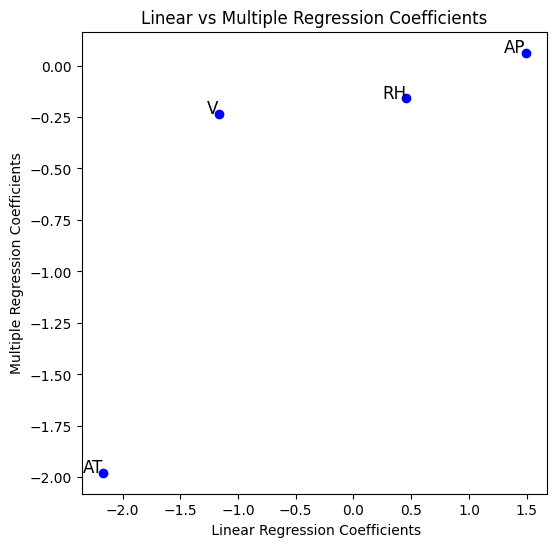

In [103]:
#1(e).

import matplotlib.pyplot as plt

#convert coefficients to lists
linear_coefs_list = list(linear_coefficients.values())
multiple_coefs_list = multiple_coefficients.tolist()

#scatter plot to compare simple vs multiple regression coefficients
plt.figure(figsize=(6, 6))
plt.scatter(linear_coefs_list, multiple_coefs_list, color="blue")

#labels for each predictor
for i, predictor in enumerate(predictors):
    plt.text(linear_coefs_list[i], multiple_coefs_list[i], predictor, fontsize=12, ha='right')

plt.xlabel(" Linear Regression Coefficients")
plt.ylabel("Multiple Regression Coefficients")
plt.title("Linear vs Multiple Regression Coefficients")  # Chart title

plt.show()


Based on this plot, we can see that AT is still the strongest predictor of PE in the Linear and Multiple Regression models. V is also still negatively correlated with PE; however, its effect is weaker in the multiple regression where the other variables are controlled. AP and RH continue to have mild effects on PE, with their effects being weaker in multiple regression and RH switches from a small positive coefficient to a negative coefficient in multiple regression.

In [104]:
#1(f).

#dictionary to store polynomial regression results
nonlinear_results = {}

#loop through each predictor to fit a polynomial regression model
for predictor in predictors:
    #polynomial features for X, X², and X³
    X_poly = df[[predictor]].copy()
    X_poly[f"{predictor}^2"] = X_poly[predictor] ** 2
    X_poly[f"{predictor}^3"] = X_poly[predictor] ** 3
    X_poly = sm.add_constant(X_poly)

    #fit a polynomial regression model
    model = sm.OLS(y, X_poly).fit()

    #store the regression summary for analysis
    nonlinear_results[predictor] = model.summary()

for predictor, summary in nonlinear_results.items():
    print(f"\nPolynomial Regression Summary for {predictor}:")
    print(summary)



Polynomial Regression Summary for AT:
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Sat, 15 Feb 2025   Prob (F-statistic):               0.00
Time:                        07:20:01   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

Yes, there's evidence of nonlinear association between AT with PE because the R-squared value increased from 0.899 to 0.912, meaning that the polynomial model explains more variance than the linear model. There's also evidence of nonlinear association between AP with PE as the R-squared value increased more moderately from 0.269 to 0.275.

In [105]:
#1(g).

#store names of interaction terms
interaction_terms = []

#create interaction terms by multiplying pairs of predictors
for i in range(len(predictors)):
    for j in range(i + 1, len(predictors)):  #avoid duplicates
        interaction_name = f"{predictors[i]}*{predictors[j]}"  #interaction term
        df[interaction_name] = df[predictors[i]] * df[predictors[j]]
        interaction_terms.append(interaction_name)

X_interaction = df[predictors + interaction_terms]
X_interaction = sm.add_constant(X_interaction)

#fit a regression model with interaction terms
interaction_model = sm.OLS(y, X_interaction).fit()

print(interaction_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Sat, 15 Feb 2025   Prob (F-statistic):               0.00
Time:                        07:20:09   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        685.7825     78.640      8.721      0.0

Yes, there is evidence of association of interactions of predictors with the response. The most signicant interaction is Temperature and Exhaust Vacuum (AT x V) as it has the greatest coefficient at 0.0210 and a statistically significant p-value of 0.000. Temperature and Relative Humidity (AT x RH), Exhaust Vacuum and Ambient Pressure (V x AP), and Ambient Pressure and Relative Humidity (AP x RH) are also significant interaction terms, but to a lesser extent.  

In [106]:
#1(h).

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools  #for predictor pairs

# Split the dataset into 70% training and 30% testing
df_train, df_test = train_test_split(df, test_size=0.3)

#separate variables for training and testing
xtrain = df_train[predictors]
ytrain = df_train["PE"]
xtest = df_test[predictors]
ytest = df_test["PE"]

xtrain = sm.add_constant(xtrain)
xtest = sm.add_constant(xtest)

#baseline model:

#fit a simple multiple linear regression model using only the original predictors
base_model = sm.OLS(ytrain, xtrain).fit()

#calculate mean squared error (MSE) for training data
ytrain_predBase = base_model.predict(xtrain)
trainMSE_base = mean_squared_error(ytrain, ytrain_predBase)

# Calculate MSE for testing data
ytest_predBase = base_model.predict(xtest)
testMSE_base = mean_squared_error(ytest, ytest_predBase)

print("\nBaseline Model Summary:")
print(base_model.summary())
print("\nBaseline Model MSE:")
print(f"Train MSE: {trainMSE_base:.4f}, Test MSE: {testMSE_base:.4f}")

#improved model:

#quadratic terms (X²) for each predictor
for predictor in predictors:
    df_train[f"{predictor}^2"] = df_train[predictor] ** 2
    df_test[f"{predictor}^2"] = df_test[predictor] ** 2

#create interaction terms by multiplying pairs of predictors
interaction_terms = []
for i in range(len(predictors)):
    for j in range(i + 1, len(predictors)):
        interaction_name = f"{predictors[i]}*{predictors[j]}" #interaction term name
        df_train[interaction_name] = df_train[predictors[i]] * df_train[predictors[j]]
        df_test[interaction_name] = df_test[predictors[i]] * df_test[predictors[j]]
        interaction_terms.append(interaction_name)

#new predictor set (original predictors, interaction terms, and quadratic terms)
xtrain_improved = df_train[predictors + interaction_terms + [f"{p}^2" for p in predictors]]
xtest_improved = df_test[predictors + interaction_terms + [f"{p}^2" for p in predictors]]

xtrain_improved = sm.add_constant(xtrain_improved)
xtest_improved = sm.add_constant(xtest_improved)

#fit the improved regression model
improved_model = sm.OLS(ytrain, xtrain_improved).fit()

#identify and keep only statistically significant predictors
significant_vars = improved_model.pvalues[improved_model.pvalues < 0.05].index.tolist()

#refit the model using only the significant predictors
xtrain_significant = xtrain_improved[significant_vars]
xtest_significant = xtest_improved[significant_vars]
final_model = sm.OLS(ytrain, xtrain_significant).fit()

#calculate training MSE for the improved model
ytrain_predImproved = final_model.predict(xtrain_significant)
trainMSE_improved = mean_squared_error(ytrain, ytrain_predImproved)

#calculate test MSE for the improved model
ytest_predImproved = final_model.predict(xtest_significant)
testMSE_improved = mean_squared_error(ytest, ytest_predImproved)

print("\nImproved Model Summary:")
print(final_model.summary())

print("\nImproved Model MSE:")
print(f"Train MSE: {trainMSE_improved:.4f}, Test MSE: {testMSE_improved:.4f}")



Baseline Model Summary:
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.144e+04
Date:                Sat, 15 Feb 2025   Prob (F-statistic):               0.00
Time:                        07:20:13   Log-Likelihood:                -19690.
No. Observations:                6697   AIC:                         3.939e+04
Df Residuals:                    6692   BIC:                         3.942e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        461.1150     1

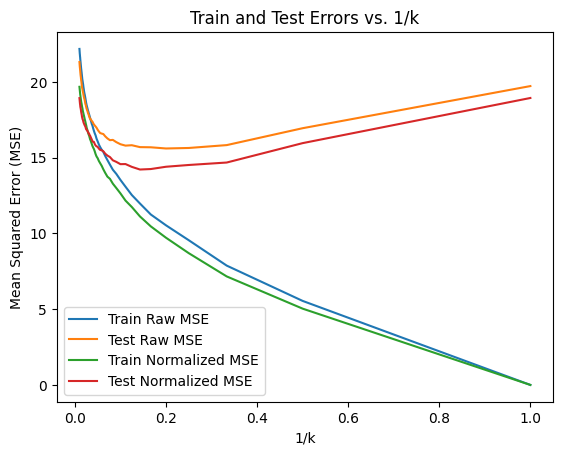

Best k for Raw Features: 5
Best k for Normalized Features: 7


In [107]:
#1(i).

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

scaler = StandardScaler()
xtrain_norm = scaler.fit_transform(xtrain)
xtest_norm = scaler.transform(xtest)

k_values = range(1, 101)

trainMSE_raw = []
testMSE_raw = []
trainMSE_norm = []
testMSE_norm = []

for k in k_values:
    #raw KNN model
    knn_raw = KNeighborsRegressor(n_neighbors=k)
    knn_raw.fit(xtrain, ytrain)
    ytrain_predRaw = knn_raw.predict(xtrain)  #predict on training data
    ytest_predRaw = knn_raw.predict(xtest)  #predict on test data
    trainMSE_raw.append(mean_squared_error(ytrain, ytrain_predRaw))  #store training error
    testMSE_raw.append(mean_squared_error(ytest, ytest_predRaw))  #store test error
    #normalized KNN Model
    knn_norm = KNeighborsRegressor(n_neighbors=k)
    knn_norm.fit(xtrain_norm, ytrain)
    ytrain_predNorm = knn_norm.predict(xtrain_norm)
    ytest_predNorm = knn_norm.predict(xtest_norm)
    trainMSE_norm.append(mean_squared_error(ytrain, ytrain_predNorm))
    testMSE_norm.append(mean_squared_error(ytest, ytest_predNorm))

plt.figure()
plt.plot(1/np.array(k_values), trainMSE_raw, label="Train Raw MSE")
plt.plot(1/np.array(k_values), testMSE_raw, label="Test Raw MSE")
plt.plot(1/np.array(k_values), trainMSE_norm, label="Train Normalized MSE")
plt.plot(1/np.array(k_values), testMSE_norm, label="Test Normalized MSE")
plt.xlabel("1/k")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Train and Test Errors vs. 1/k")
plt.legend()
plt.show()

#find the best k values (minimum test MSE)
best_k_raw = k_values[np.argmin(testMSE_raw)]
best_k_norm = k_values[np.argmin(testMSE_norm)]

print(f"Best k for Raw Features: {best_k_raw}")
print(f"Best k for Normalized Features: {best_k_norm}")



1(j).

KNN Regression using normalized features has a lower test error than Linear Regression's (14.66 < 19.35), meaning that the KNN regression captures the nonlinear relationships in the data better. The normalized KNN model performs better than the raw KNN model based the lower test error The normalized model's best k-value is k = 6 with its test error at 14.66 and the raw model's best k-value is k = 7 with its test error being 15.73.

2 (ISLR: 2.4.1):

a. A flexible statistical learning method would perform worse than an inflexible method because since the sample size n is large, the lower variance of the inflexible method would help because they are less sensitive to fluctuations in the training data.

b. A flexible statistical learning method would be worse than inflexible methods because the larger p could cause overfitting. There are too many parameters relative to observations.

c. A flexible statistical learning method would be better because inflexible methods typically work better for linear relationships and fail when the relationship is highly nonlinear.

d. A flexible statistical learning method would be worse than an inflexible method because when the error variance is extremely high, flexible models can cause overfitting and inflexible methods provide more stability, reducing variance.

In [108]:
#3
#part a
data = pd.DataFrame({
    "obs": [1, 2, 3, 4, 5, 6],
    "x1": [0, 2, 0, 0, -1, 1],
    "x2": [3, 0, 1, 1, 0, 1],
    "x3": [0, 0, 3, 2, 1, 1],
    "y": ["Red", "Red", "Red", "Green", "Green", "Red"]
})

#define a test point where we want to predict the class
test_point = np.array([0, 0, 0]) # x1=0, x2=0, x3=0

#calculate Euclidean distance from the test point to each data point
data["distance"] = np.sqrt(
    (data["x1"] - test_point[0])**2 +
    (data["x2"] - test_point[1])**2 +
    (data["x3"] - test_point[2])**2
)

#sort the dataset by distance (closest points first)
data_sorted = data.sort_values(by="distance")
print("3a. Computed distances from the test point:\n", data_sorted[["obs", "distance", "y"]])

#part b
k1_prediction = data_sorted.iloc[0]["y"]
print(f"\n3b. Predicted class for K=1: {k1_prediction}")

#part c
k3_prediction = data_sorted.iloc[:3]["y"].mode()[0]
print(f"\n3c. Predicted class for K=3: {k3_prediction}")

#part d
print("\n3d. A smaller K value captures local patterns better, while a larger K smooths out the decision boundary, potentially missing important details.")


3a. Computed distances from the test point:
    obs  distance      y
4    5  1.414214  Green
5    6  1.732051    Red
1    2  2.000000    Red
3    4  2.236068  Green
0    1  3.000000    Red
2    3  3.162278    Red

3b. Predicted class for K=1: Green

3c. Predicted class for K=3: Red

3d. A smaller K value captures local patterns better, while a larger K smooths out the decision boundary, potentially missing important details.
